In [1]:
%pip install segmentation-models-pytorch
%pip install -U git+https://github.com/albumentations-team/albumentations
%pip install --upgrade opencv-contrib-python

Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/albumentations-team/albumentations to c:\users\lab30\appdata\local\temp\pip-req-build-c8ub9der
  Resolved https://github.com/albumentations-team/albumentations to commit 66212d77a44927a29d6a0e81621d3c27afbd929c
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached albucore-0.0.28-py3-none-any.whl.metadata (5.3 kB)
Using cached albucore-0.0.28-py3-none-any.whl (18 kB)
  Created wheel for albumentations: filename=albumentations-2.0.8-py3-none-any.whl size=379747 sha256=033698f4eadcd48e795e571f06e30a3061b872e05fa37fb111f1abfdc45a0572
  Stored in directory: C:\Users\lab30\AppData\Local\Temp\pip-ephem-wheel-cach

  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations 'C:\Users\lab30\AppData\Local\Temp\pip-req-build-c8ub9der'
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentationsx 2.0.9 requires albucore==0.0.33, but you have albucore 0.0.28 which is incompatible.


Note: you may need to restart the kernel to use updated packages.


# Download dataset
original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset

In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


# Some common import

In [3]:
import sys
sys.path.append('C:/Users/lab30/Documents/01_Cranial_Project/Unet_model/Human-Segmentation-Dataset-master')

In [4]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper # type: ignore

# Setup Configurations

In [5]:
CSV_FILE = 'Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = ''

DEVICE = 'cuda'
# DEVICE = 'cpu'

EPOCHS = 25
LR = 0.003
IMAGE_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [6]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [7]:
row = df.iloc[4]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0
mask = np.expand_dims(mask, axis = -1)

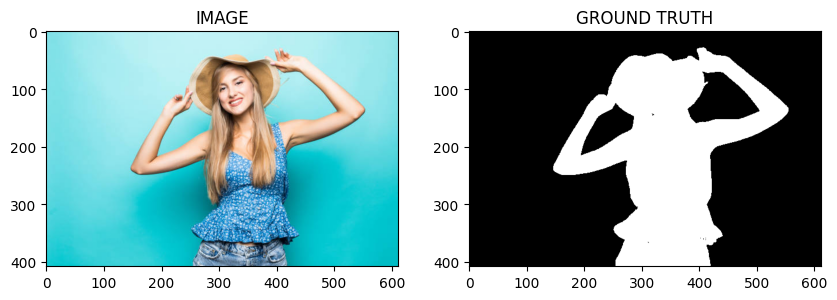

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [9]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)

# Augmentation Functions
albumentation documentation : https://albumentations.ai/docs/

In [10]:
import albumentations as A

In [11]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE),
      A.HorizontalFlip(p = 0.5),
      A.VerticalFlip(p = 0.5)
  ], is_check_shapes=False) # Disable shape check
  # def get_train_augs():
  # return A.Compose([
  #     A.Resize(IMAGE_SIZE, IMAGE_SIZE),
  #     A.HorizontalFlip(p = 0.5),
  #     A.VerticalFlip(p = 0.5)
  # ]) # Disable shape check

def get_valid_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE)
  ], is_check_shapes = False) # Disable shape check

# Create custom Dataset

In [12]:
from torch.utils.data import Dataset

In [13]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):

    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):

    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0 #(h, w, c)
    mask = np.expand_dims(mask, axis = -1)


    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']

    #(h,w,c) -> (c,h,W)
    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)


    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask))

    return image, mask

In [14]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [15]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


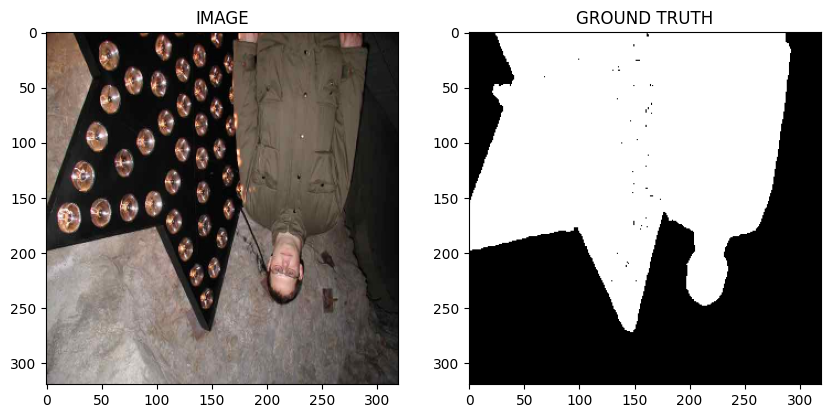

In [16]:
idx = 56

image, mask = trainset[idx]
helper.show_image(image, mask)

# Load dataset into batches

In [17]:
from torch.utils.data import DataLoader

In [18]:
trainLoader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validLoader = DataLoader(validset, batch_size = BATCH_SIZE)

In [19]:
print(f"total no. of batches in trainloader : {len(trainLoader)}")
print(f"total no. of batches in validloader : {len(validLoader)}")

total no. of batches in trainloader : 15
total no. of batches in validloader : 4


In [20]:
for image, mask in trainLoader:
  break

print(f"One batch image shape: {image.shape}")
print(f"One batch mask shape: {mask.shape}")

One batch image shape: torch.Size([16, 3, 320, 320])
One batch mask shape: torch.Size([16, 1, 320, 320])


# Create segmentation model

In [21]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [22]:
# Declare model
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.model = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self, images, masks = None):
    logits = self.model(images)
    if masks != None:
      loss1 = DiceLoss(mode = 'binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2
    return logits

In [23]:
model = SegmentationModel()
model.to(DEVICE)

SegmentationModel(
  (model): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (aa): Identity()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigm

# Create Train and Validation Function

In [24]:
def train_fn(data_loader, model, optimizer):

  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(data_loader)

In [25]:
def eval_fn(data_loader, model):

  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      # optimizer.zero_grad()
      logits, loss = model(images, masks)
      # loss.backward()
      # optimizer.step()

      total_loss += loss.item()

    return total_loss / len(data_loader)

# Train model

In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [27]:
best_valid_loss = np.inf

for i in range(EPOCHS):

  train_loss = train_fn(trainLoader, model, optimizer)
  valid_loss = eval_fn(validLoader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("SAVED MODEL")
    best_valid_loss = valid_loss

  print(f"EPOCH : {i+1} Train_loss : {train_loss} Valid_loss : {valid_loss}")

100%|██████████| 4/4 [00:00<00:00,  9.53it/s]


SAVED MODEL
EPOCH : 1 Train_loss : 0.7990063627560934 Valid_loss : 0.8267132937908173


100%|██████████| 4/4 [00:00<00:00,  9.72it/s]


SAVED MODEL
EPOCH : 2 Train_loss : 0.37549771666526793 Valid_loss : 0.3629429414868355


100%|██████████| 4/4 [00:00<00:00,  9.88it/s]


SAVED MODEL
EPOCH : 3 Train_loss : 0.29822037120660144 Valid_loss : 0.2839572951197624


100%|██████████| 4/4 [00:00<00:00,  9.92it/s]


SAVED MODEL
EPOCH : 4 Train_loss : 0.28168538212776184 Valid_loss : 0.24307889118790627


100%|██████████| 4/4 [00:00<00:00,  9.87it/s]


SAVED MODEL
EPOCH : 5 Train_loss : 0.22818798919518787 Valid_loss : 0.23040272295475006


100%|██████████| 4/4 [00:00<00:00,  9.95it/s]


EPOCH : 6 Train_loss : 0.2232905924320221 Valid_loss : 0.23403237015008926


100%|██████████| 4/4 [00:00<00:00, 10.12it/s]


SAVED MODEL
EPOCH : 7 Train_loss : 0.1560287112991015 Valid_loss : 0.20351066440343857


100%|██████████| 4/4 [00:00<00:00, 10.03it/s]


EPOCH : 8 Train_loss : 0.19440176735321682 Valid_loss : 0.2505445145070553


100%|██████████| 4/4 [00:00<00:00,  9.72it/s]


EPOCH : 9 Train_loss : 0.1864955186843872 Valid_loss : 0.20524199679493904


100%|██████████| 4/4 [00:00<00:00,  9.82it/s]


SAVED MODEL
EPOCH : 10 Train_loss : 0.16498772352933883 Valid_loss : 0.1947297677397728


100%|██████████| 4/4 [00:00<00:00,  9.72it/s]


EPOCH : 11 Train_loss : 0.14916300624608994 Valid_loss : 0.20433496311306953


100%|██████████| 4/4 [00:00<00:00,  9.97it/s]


SAVED MODEL
EPOCH : 12 Train_loss : 0.14679465641578038 Valid_loss : 0.1778005249798298


100%|██████████| 4/4 [00:00<00:00, 10.14it/s]


EPOCH : 13 Train_loss : 0.1483319416642189 Valid_loss : 0.2205110527575016


100%|██████████| 4/4 [00:00<00:00,  9.92it/s]


EPOCH : 14 Train_loss : 0.15298162996768952 Valid_loss : 0.22115707024931908


100%|██████████| 4/4 [00:00<00:00,  9.80it/s]


EPOCH : 15 Train_loss : 0.12335828493038813 Valid_loss : 0.1871296800673008


100%|██████████| 4/4 [00:00<00:00, 10.21it/s]


EPOCH : 16 Train_loss : 0.13897957652807236 Valid_loss : 0.19670720025897026


100%|██████████| 4/4 [00:00<00:00,  9.97it/s]


EPOCH : 17 Train_loss : 0.1383699009815852 Valid_loss : 0.19919315725564957


100%|██████████| 4/4 [00:00<00:00, 10.03it/s]


EPOCH : 18 Train_loss : 0.1312915896375974 Valid_loss : 0.2258933037519455


100%|██████████| 4/4 [00:00<00:00,  9.96it/s]


EPOCH : 19 Train_loss : 0.12653321425120037 Valid_loss : 0.19543102756142616


100%|██████████| 4/4 [00:00<00:00, 10.12it/s]


EPOCH : 20 Train_loss : 0.10752386649449666 Valid_loss : 0.19745314866304398


100%|██████████| 4/4 [00:00<00:00,  9.98it/s]


EPOCH : 21 Train_loss : 0.1614160418510437 Valid_loss : 0.2990048862993717


100%|██████████| 4/4 [00:00<00:00,  9.96it/s]


EPOCH : 22 Train_loss : 0.13524931867917378 Valid_loss : 0.2700873427093029


100%|██████████| 4/4 [00:00<00:00, 10.03it/s]


SAVED MODEL
EPOCH : 23 Train_loss : 0.12524665395418802 Valid_loss : 0.16988619044423103


100%|██████████| 4/4 [00:00<00:00,  9.81it/s]


EPOCH : 24 Train_loss : 0.11935981661081314 Valid_loss : 0.20145615190267563


100%|██████████| 4/4 [00:00<00:00, 10.08it/s]

EPOCH : 25 Train_loss : 0.10884366234143575 Valid_loss : 0.22516867518424988


# Inference

In [38]:
idx = 27

model.load_state_dict(torch.load('best_model.pt'))   

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) # (C, H, W) -> (1, C, H, W)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0

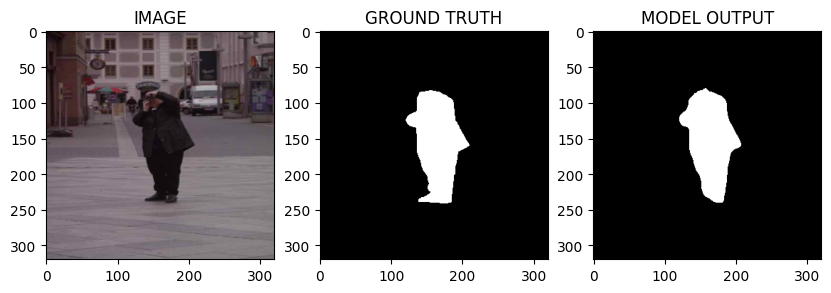

In [39]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))